# Example: Analyzing ENCODE H3K4me3 data in hESC Cells

## Xuan Cao Ph.D.
## Guo-Cheng Yuan Ph.D. . Yuan Lab: [labs.icahn.mssm.edu/yuanlab/](labs.icahn.mssm.edu/yuanlab/)
## 2023-12-28

### In this tutorial we describe the  steps to running diHMM-cpp for ENCODE H3K4me3 data in hESC Cells.

### Data used in the tutorial is freely accessible at: [https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM409nnn/GSM409308/suppl/GSM409308%5FUCSD.H1.H3K4me3.LL227.wig.gz](https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM409nnn/GSM409308/suppl/GSM409308%5FUCSD.H1.H3K4me3.LL227.wig.gz)

### Output files are available at: [https://github.com/gcyuan/diHMM-cpp/tree/master/Tutorial](https://github.com/gcyuan/diHMM-cpp/tree/master/Tutorial)


# 1. Downlaod and pre-process data 

- For generating a diHMM model you will require files with either of them: wig, bigwig or bedgraph format.
- The files need to be swithed into bedgraph for binarizing. 
- Here we used the wig file as an example.

## 1.1. Download the ENCODE H3K4me3 wig file

In [ ]:
# download wig data
wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM409nnn/GSM409308/suppl/GSM409308%5FUCSD.H1.H3K4me3.LL227.wig.gz
gzip -d GSM409308_UCSD.H1.H3K4me3.LL227.wig.gz

In [ ]:
# downlaod the tools required
wget https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64.v369/wigToBigWig
wget https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64.v369/fetchChromSizes
wget https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64.v369/bigWigToBedGraph

## 1.2. Change wig format to bedgraph format

In [ ]:
./fetchChromSizes hg19 > hg19.chrom.sizes
cat hg19.chrom.sizes|grep -v random|grep -v chrUn|grep -v hap|grep -v chrM|grep -v chrY|\
sort -k1,1 > hg19.chrom.sizes.sort

./wigToBigWig GSM409308_UCSD.H1.H3K4me3.LL227.wig hg19.chrom.sizes GSM409308_UCSD.H1.H3K4me3.LL227.bigwig
./bigWigToBedGraph GSM409308_UCSD.H1.H3K4me3.LL227.bigwig GSM409308_UCSD.H1.H3K4me3.LL227.bedgraph

## 1.3. create bedgrpah file at 100bp resolution

- Each data was binarized at the resolution of 100bp. This resolution can be set by users.

In [ ]:
bedtools makewindows -g hg19.chrom.sizes.sort -w 100 |\
bedtools map -a - -b GSM409308_UCSD.H1.H3K4me3.LL227.bedgraph -c 4 -o mean |\
awk '{if ($4 != "." && $4 > 0 ){print $0}}' \
> GSM409308_UCSD.H1.H3K4me3.LL227.100bp.bedgraph

# 2. Generate binarized files

- The input file for diHMM-cpp is the binarized data. Here we provide the steps for generating binarized files from the bedgraph files.
- We used script bdg_to_binarize.sh in diHMM-cpp package.
- The output files in this step will used as input file in diHMM-cpp. Please check your binarized file have the same format with the example here.

### code used for create binarized file

In [ ]:
diHMM-cpp/bdg_to_binarize.sh --help
-i input bedgraph file
-o output dir
-m histone mark
-t cell type or sample name
-s binsize
-c chrom.size file path
-f the cutoff used to binarize file, greater than this value

## 2.1 running binarizing

In [ ]:
sh diHMM-cpp/bdg_to_binarize.sh \
-i GSM409308_UCSD.H1.H3K4me3.LL227.100bp.bedgraph \
-o 1.binary \
-m H3K4me3 \
-t H1 \
-s 100 \
-c hg19.chrom.sizes \
-f 2

### Note: -f is the cutoff( greater than) to binarize the file, it should be defined by manually visualizing the bigwig signal in the genome browser using file 100bp.bedgraph . 

## 2.2 The outputs files of binarized files

### Out put binarized files under the output folder

In [ ]:
ls 1.binary/*
H1_chr10_binary.txt  H1_chr16_binary.txt  H1_chr21_binary.txt  H1_chr6_binary.txt
H1_chr11_binary.txt  H1_chr17_binary.txt  H1_chr22_binary.txt  H1_chr7_binary.txt
H1_chr12_binary.txt  H1_chr18_binary.txt  H1_chr2_binary.txt   H1_chr8_binary.txt
H1_chr13_binary.txt  H1_chr19_binary.txt  H1_chr3_binary.txt   H1_chr9_binary.txt
H1_chr14_binary.txt  H1_chr1_binary.txt   H1_chr4_binary.txt   H1_chrX_binary.txt
H1_chr15_binary.txt  H1_chr20_binary.txt  H1_chr5_binary.txt

### Each output file

In [ ]:
head 1.binary/H1_chr1_binary.txt 
H1      chr1
H3K4me3
0
0
0
0
0
0
0
0

## 2.3 create bed format of binary file
- The bed files can be imported into IGV for visualizing the binarization.

In [ ]:
# create output dir
mkdir 1.binary_bed
out_file=1.binary_bed/H1_binary.bed
touch $out_file

mark="H3K4me3"  # -m from dihmm-cpp/bdg_to_binarize.sh
chrom_size="hg19.chrom.sizes.sort"
chrs=(chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr2 chr20 chr21 chr22 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chrX)
for chr in ${chrs[@]}
do
        input_file=1.binary/H1_${chr}_binary.txt
        bin_chr_file=1.binary_bed/${chr}.bed
        grep -w $chr $chrom_size|bedtools makewindows -g - -w 100 > $bin_chr_file
        cat $input_file|grep -v chr |grep -v $mark|paste $bin_chr_file -|perl -alne 'print if $F[3] == 1' >> $out_file
        rm $bin_chr_file
done


# 3. Training diHMM models 

- The main step is training diHMM models. Here used the script "Train_diHMM.py" for training models.
- DiHMM-cpp implemented in C++ to increase computational efficiency.
- DiHMM used the binarized data tracks as input and annotates the combinatorial chromatin states at multiple length scales: nucleosome-level states and domain-level states.
- Here we train a diHMM models for chr1 and chr2 seperately.
- Here we provide the output folder structure and file format in this section.
- Please make sure running diHMM-cpp under the correct environment.

In [ ]:
# activate conda environment for diHMM
conda activate dihmm

In [ ]:
python dihmm-cpp/Train_diHMM.py -h
usage: Train_diHMM.py [-h] -i INPUT_DIR --clusters CLUSTERS --chroms CHROMS
                         -o OUT_DIR [--n_bin_states N_BIN_STATES]
                         [--n_domain_states N_DOMAIN_STATES]
                         [--domain_size DOMAIN_SIZE] [--tolerance TOLERANCE]
                         [--max_iter MAX_ITER] [--bin_res BIN_RES]

Train diHMM runner.

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT_DIR          The input binarized files dir. File name:
                        X1_chr1_binary.txt.
  --clusters CLUSTERS   Clusters/cell_types names used to train model.
                        Example: X1,X2 .
  --chroms CHROMS       chrs used to train model. Example: chr1,chr2 .
  -o OUT_DIR            Output dir.
  --n_bin_states N_BIN_STATES
                        Number of bin states. Default=2.
  --n_domain_states N_DOMAIN_STATES
                        Number of domain states. Default=4.
  --domain_size DOMAIN_SIZE
                        Number of domain size. Default=8.
  --tolerance TOLERANCE
                        Number of bin states. Default=1e-6.
  --max_iter MAX_ITER   Max iter number. Default=500.
  --bin_res BIN_RES     bin length used to generate binarized files.
                        Default=500.

## 3.1 Running diHMM for chr1 and chr2

In [ ]:
python diHMM-cpp/Train_diHMM.py \
-i 1.binary/ \
-o 2.diHMM_out \
--clusters H1 \
--chroms chr1,chr2 \
--n_bin_states 2 \
--n_domain_states 2 \
--domain_size 5 \
--bin_res 100

- For training diHMM models, here we trained model for chr1 and chr2 seperately. 

### The recording of running log

In [ ]:
FILE PATH 1.binary//H1_chr1_binary.txt
FILE PATH 1.binary//H1_chr2_binary.txt
2492505
2431990
BIN POSITIONS 2492505
BIN POSITIONS 2431990
Initial log likelihood: -inf
Finished forward probabilities
Finished forward probabilities
Finished backwards probabilities
Starting intermediate model update
bin positions 2492505
num threads: 19
Finished backwards probabilities
Starting intermediate model update
bin positions 2431990
num threads: 19
Finished intermediate model update
Finished intermediate model update
finished computation at Thu Dec 28 17:41:49 2023
elapsed time: 2.76965s
Current iteration: 0
Delta in likelihood: inf
Converged: 0
Old ll: -inf
New ll: -582892
Finished forward probabilities
Finished forward probabilities
Finished backwards probabilities
Starting intermediate model update
bin positions 2431990
num threads: 19
Finished backwards probabilities
Starting intermediate model update
bin positions 2492505
num threads: 19
Finished intermediate model update
Finished intermediate model update
finished computation at Thu Dec 28 17:41:51 2023
elapsed time: 1.70761s
Current iteration: 1
Delta in likelihood: 486121
Converged: 1
Old ll: -582892
New ll: -96770.9
Start annotation
FILE PATH 1.binary//H1_chr1_binary.txt
start write bed
process 2.diHMM_out/anno//H1_chr1
FILE PATH  1.binary//H1_chr2_binary.txt
start write bed
process 2.diHMM_out/anno//H1_chr2
('The time caused is : ', datetime.timedelta(0, 22, 171907), '\n')

### Resource required

In [ ]:
Resource usage summary:

    CPU time :                                   22.36 sec.
    Max Memory :                                 2568 MB
    Average Memory :                             546.94 MB
    Total Requested Memory :                     50000.00 MB
    Delta Memory :                               47432.00 MB
    Max Swap :                                   -
    Max Processes :                              3
    Max Threads :                                60
    Run time :                                   27 sec.
    Turnaround time :                            47 sec.

## 3.2 output files  

In [ ]:
The output files under folder: 2.diHMM_out/anno/

For each chr, we have two bed files: bin_states.bed and domain_states.bed

The output files under 2.diHMM_out/anno/: 
H1_chr1_bin_states.bed     
H1_chr1_domain_states.bed
H1_chr2_bin_states.bed
H1_chr2_domain_states.bed

The states were recorded at the forth columns in output files.

In [ ]:
# output of bin_states.bed
head 2.diHMM_out/anno/H1_chr1_bin_states.bed 

track   name="H1_chr1_bin_states"       description="H1_chr1_bin_states"        visibility=1 itemRgb="on"
chr1    0       713200  N0      0       .       0       713200  0,0,128
chr1    713200  715300  N1      0       .       713200  715300  125,255,122
chr1    715300  762000  N0      0       .       715300  762000  0,0,128
chr1    762000  763400  N1      0       .       762000  763400  125,255,122
chr1    763400  839700  N0      0       .       763400  839700  0,0,128
chr1    839700  841300  N1      0       .       839700  841300  125,255,122
chr1    841300  858700  N0      0       .       841300  858700  0,0,128
chr1    858700  860900  N1      0       .       858700  860900  125,255,122
chr1    860900  861000  N0      0       .       860900  861000  0,0,128

In [ ]:
head 2.diHMM_out/anno/H1_chr1_domain_states.bed 

track   name="H1_chr1_domain_states"    description="H1_chr1_domain_states"     visibility=1 itemRgb="on"
chr1    0       713000  N1      0       .       0       713000  125,255,122
chr1    713000  715000  N0      0       .       713000  715000  0,0,128
chr1    715000  762000  N1      0       .       715000  762000  125,255,122
chr1    762000  763000  N0      0       .       762000  763000  0,0,128
chr1    763000  839500  N1      0       .       763000  839500  125,255,122
chr1    839500  841000  N0      0       .       839500  841000  0,0,128
chr1    841000  858500  N1      0       .       841000  858500  125,255,122
chr1    858500  861500  N0      0       .       858500  861500  0,0,128
chr1    861500  875000  N1      0       .       861500  875000  125,255,122

# 4. Visualization of the diHMM output

- It is convenient to visualize the ChIPseq signal (bedgraph), binarized, diHMM nucleosome-level state(Bin_states) and domain-level states (Domain_states) in the genome browser IGV.  

>- Bin_states have N1 and N0. From the image, the state N1 represent the nucleosome-level state.
>- Domain_states have N1 and N0. From the image, the state N0 represent the domain-level state.

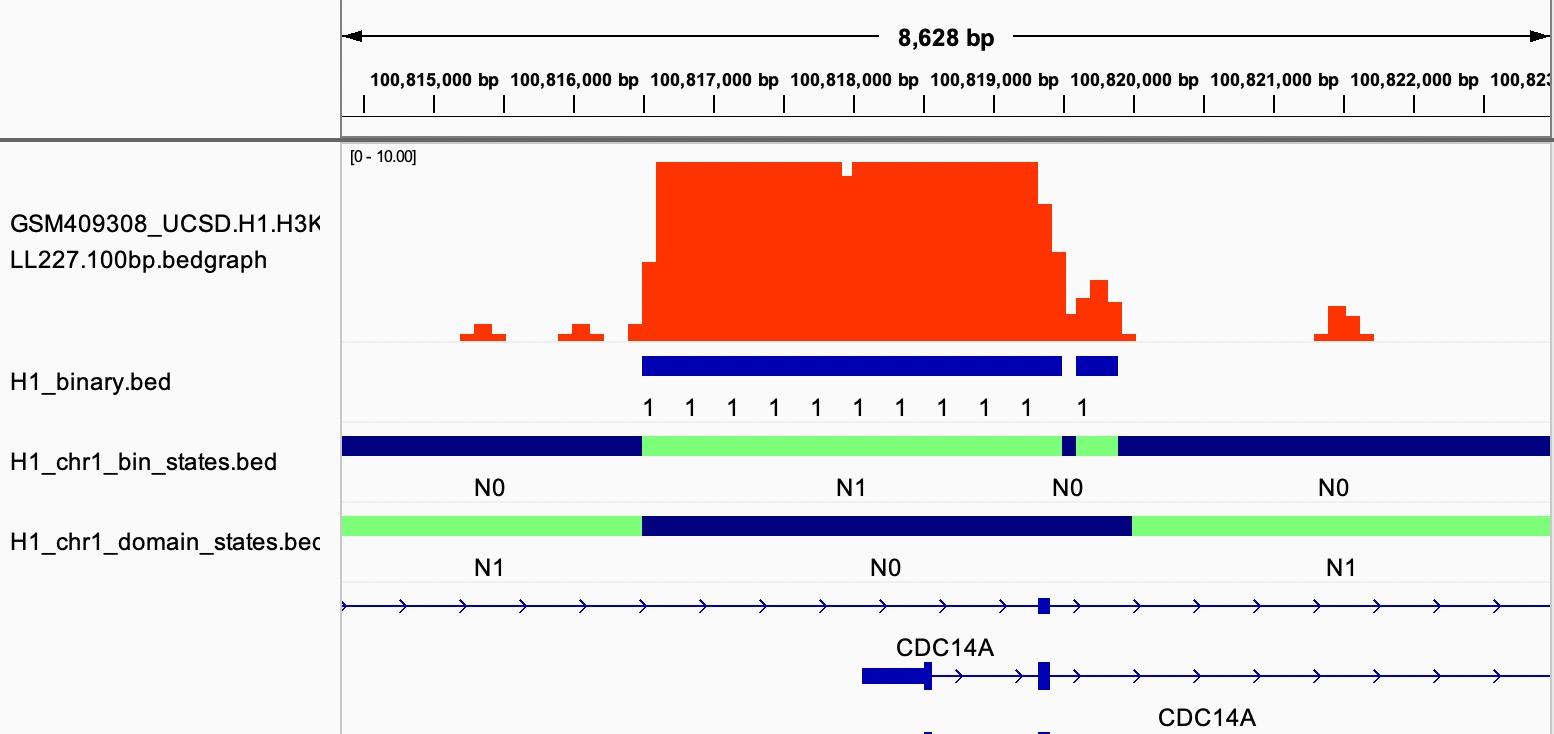